In [1]:
import os
import pickle
from src.util import plotting_util as plutil

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)
METIENT_OUTPUT_DIR = os.path.join(REPO_DIR, 'src/data/tracerx_nsclc/metient_outputs')
ORCHARD_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, 'pyclone_clustered_orchard_trees')
CONIPHER_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, 'pyclone_clustered_conipher_trees')
TRACERX_DATA_DIR = os.path.join(REPO_DIR, "src/data/tracerx_nsclc/")

MONO_COLOR = "#6aa84fff"
POLY_COLOR = "#2496c8ff"

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
def get_patients(pickle_files_dir):
    patients = []
    for file in os.listdir(pickle_files_dir):
        if ".pickle" in file:
            patients.append(file.split(".")[0])
    return patients

def patient_in_dict(dct, patient):
    for patient_primary in dct:
        if patient == patient_primary.split("_")[0]:
            return True, patient_primary, dct[patient_primary]
    return False, None, None

def is_better_pattern(old_pattern, new_pattern):
    if "monoclonal" in new_pattern or "monophyletic" in new_pattern:
        return True
    return False
    
def get_info(pickle_files_dir):
    patients = get_patients(pickle_files_dir)
    seeding_patterns = dict()
    monoclonal_ct = 0
    for patient in patients:
        file = open(os.path.join(pickle_files_dir, f"{patient}.pickle"),'rb')
        pckl = pickle.load(file)
        V = pckl['ancestral_labelings'][0]
        A = pckl['full_adjacency_matrices'][0]
        idx_to_label = pckl['full_node_idx_to_label'][0]
        sites = pckl['ordered_anatomical_sites']
        primary_label =  "_".join(patient.split("_")[1:]) # TODO: swap this when pickle files get saved w primary
        pattern = plutil.get_tracerx_seeding_pattern(V, A, sites, primary_label,idx_to_label)
        
        # For patients with multiple primaries
        patient_name = patient.split("_")[0]
        if patient_name in seeding_patterns:
            prev_pattern = seeding_patterns[patient_name]
            # choose the run with the primary that was more parsimonious
            if is_better_pattern(prev_pattern, pattern):
                seeding_patterns[patient_name] = pattern
        else:
            seeding_patterns[patient_name] = pattern

    for patient in seeding_patterns:
        if "monoclonal" in seeding_patterns[patient]:
            monoclonal_ct += 1
    print(f"{len(seeding_patterns)} patients")
    print(f"# monoclonal cases: {monoclonal_ct}, # polyclonal cases: {len(patients)-monoclonal_ct}")
    return seeding_patterns, monoclonal_ct

### Load metient outputs using various combinations of clustering alg + tree inference alg + metient hyperparams

In [3]:
# (1) pyclone clusters + conipher trees + metient (maximum parsimony)
conipher_mp_patterns, _ = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'max_pars'))

# (2) pyclone clusters + conipher trees + metient (maximum parsimony + genetic distance)
conipher_mp_gd_seeding_patterns, _ = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'max_pars_genetic_distance'))

# (3) pyclone clusters + orchard trees + metient (maximum parsimony)
orchard_mp_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars'))

# (4) pyclone clusters + orchard trees + metient (maximum parsimony + genetic distance)
orchard_mp_gd_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars_genetic_distance'))
conipher_mp_gd_seeding_patterns

126 patients
# monoclonal cases: 48, # polyclonal cases: 80
126 patients
# monoclonal cases: 47, # polyclonal cases: 81
126 patients
# monoclonal cases: 52, # polyclonal cases: 76
125 patients
# monoclonal cases: 48, # polyclonal cases: 78


{'CRUK0495': 'monoclonal monophyletic',
 'CRUK0284': 'polyclonal polyphyletic',
 'CRUK0497': 'polyclonal polyphyletic',
 'CRUK0041': 'no seeding',
 'CRUK0236': 'monoclonal monophyletic',
 'CRUK0418': 'no seeding',
 'CRUK0737': 'monoclonal monophyletic',
 'CRUK0044': 'monoclonal monophyletic',
 'CRUK0872': 'polyclonal polyphyletic',
 'CRUK0245': 'polyclonal polyphyletic',
 'CRUK0584': 'polyclonal polyphyletic',
 'CRUK0693': 'no seeding',
 'CRUK0325': 'polyclonal polyphyletic',
 'CRUK0361': 'monoclonal monophyletic',
 'CRUK0572': 'polyclonal polyphyletic',
 'CRUK0453': 'monoclonal monophyletic',
 'CRUK0412': 'no seeding',
 'CRUK0636': 'monoclonal monophyletic',
 'CRUK0519': 'monoclonal monophyletic',
 'CRUK0097': 'monoclonal monophyletic',
 'CRUK0299': 'polyclonal polyphyletic',
 'CRUK0596': 'polyclonal polyphyletic',
 'CRUK0178': 'polyclonal polyphyletic',
 'CRUK0444': 'polyclonal polyphyletic',
 'CRUK0084': 'monoclonal monophyletic',
 'CRUK0337': 'monoclonal monophyletic',
 'CRUK0524':

### Get sample info

In [4]:
import pandas as pd
sample_info_df= pd.read_csv(os.path.join(TRACERX_DATA_DIR,"sample_overview_original.txt"), sep="\t")
print(sample_info_df.head())


  patient_id tumour_id             region  sampleType sampleTypeDetail
0   CRUK0010  CRUK0010  CRUK0010_SU_T1.R1     primary          primary
1   CRUK0010  CRUK0010  CRUK0010_SU_T1.R2     primary          primary
2   CRUK0010  CRUK0010   CRUK0010_SU_FLN1  metastasis               LN
3   CRUK0010  CRUK0010    CRUK0010_BR_LN1  metastasis  metachronousMet
4   CRUK0010  CRUK0010    CRUK0010_BR_LN2  metastasis  metachronousMet


### How often are samples monoclonal vs. polyclonal?

{'mono_poly': ['monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'mono

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 61.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 45.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 61.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 45.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

<Figure size 640x480 with 0 Axes>

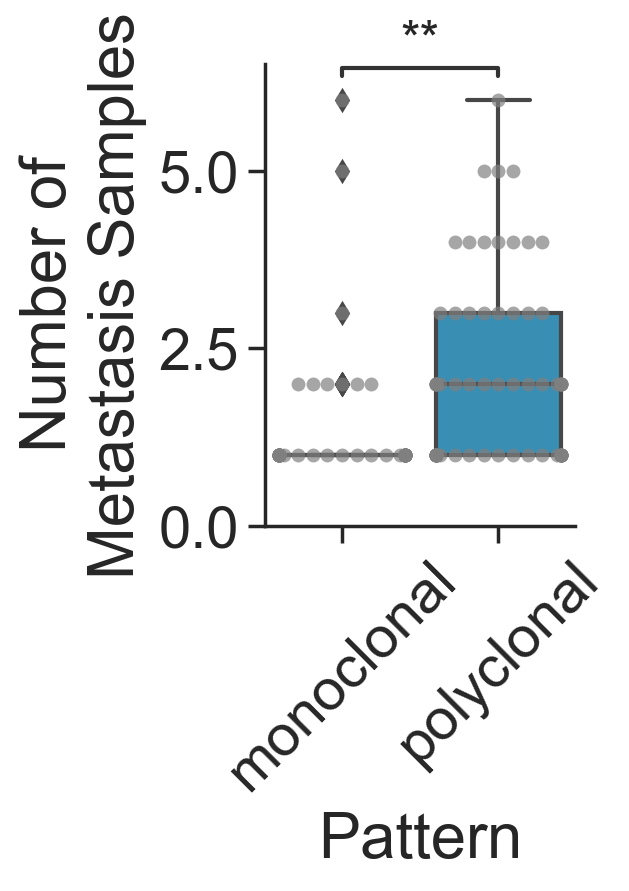

In [5]:
def get_num_met_samples(patient_id):
    sample_types = sample_info_df[sample_info_df['patient_id']==patient_id]['sampleType']
    return sample_types.value_counts()['metastasis']
    
mono_poly_data = {"mono_poly" : [], "num_samples" : [], "patient":[]}
for key, pattern in conipher_mp_gd_seeding_patterns.items():
    patient = key.split("_")[0]
    # TODO: investigate these no seeding cases
    if (pattern.split()[0]=="no"):
        continue
    mono_poly_data['patient'].append(patient)
    mono_poly_data["mono_poly"].append(pattern.split()[0])
    mono_poly_data["num_samples"].append(get_num_met_samples(patient))
print(mono_poly_data)
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(2, 3), dpi=200)
palette = {"monoclonal":MONO_COLOR, "polyclonal":POLY_COLOR}
snsfig = sns.boxplot(x='mono_poly', y='num_samples', data=mono_poly_data, order=["monoclonal", "polyclonal"], linewidth=1.5, palette=palette, showfliers=True)
sns.swarmplot(x='mono_poly', y='num_samples', data=mono_poly_data, color="grey", dodge=False, alpha=0.7)  # Scatter plot
add_stat_annotation(snsfig, data=mono_poly_data, x='mono_poly', y='num_samples',
                    box_pairs=[("monoclonal", "polyclonal")], test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)
plt.ylim(0, 6.5) 
plt.xlabel("Pattern")
plt.ylabel("Number of \nMetastasis Samples")
plt.xticks(rotation=45)
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
fig.savefig(os.path.join(REPO_DIR, "src/test", f"mono_vs_poly_num_samples.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

<Figure size 640x480 with 0 Axes>

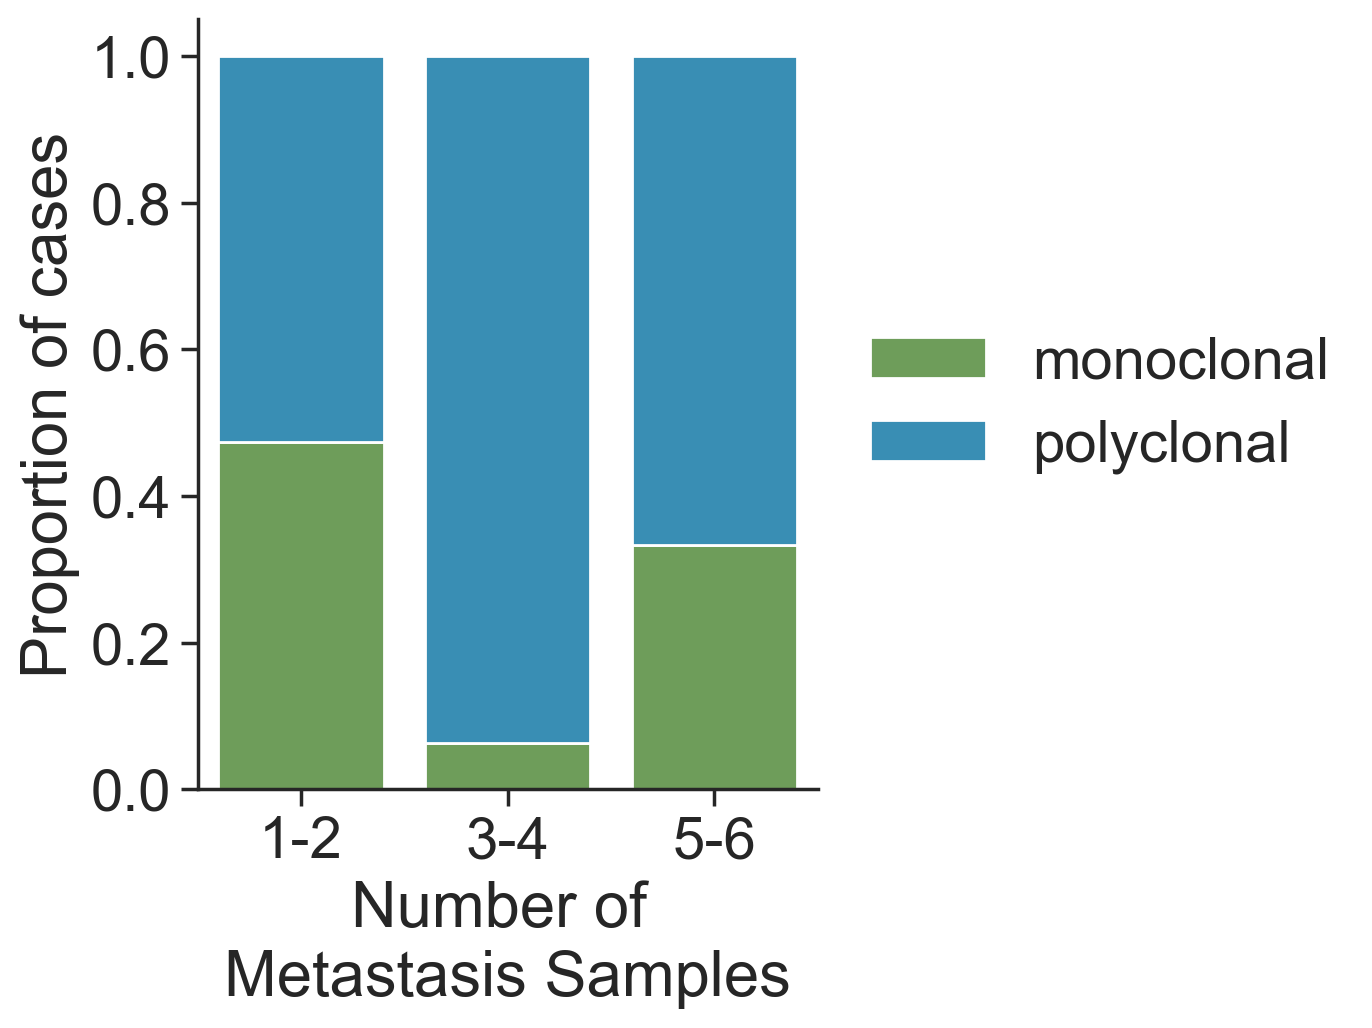

In [6]:
sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(4, 5), dpi=200)
palette = {"monoclonal":"#00A088", "polyclonal":"#3B5587"}

# Create a DataFrame
num_samples_df = pd.DataFrame(mono_poly_data)

# Define the num_sites ranges
num_samples_df['num_samples_range'] = pd.cut(num_samples_df['num_samples'], bins=[0, 2, 4, 6], labels=["1-2", "3-4", "5-6"])

# Calculate the proportions of monoclonal and polyclonal within each range
proportions = num_samples_df.groupby(['num_samples_range', 'mono_poly']).size().unstack(fill_value=0).div(num_samples_df.groupby('num_samples_range').size(), axis=0)

# Reset the index
proportions.reset_index(inplace=True)

# Create a stacked bar plot
ax1 = sns.barplot(x='num_samples_range', y='monoclonal', data=proportions, color=MONO_COLOR, label='monoclonal')
ax2 = sns.barplot(x='num_samples_range', y='polyclonal', data=proportions, color=POLY_COLOR, bottom=proportions['monoclonal'], label='polyclonal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add labels and legend
plt.xlabel("Number of \nMetastasis Samples")
plt.ylabel("Proportion of cases")
plt.title("")
plt.legend(title="",  loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Show the plot
plt.show()
fig.savefig(os.path.join(REPO_DIR, "src/test", f"mono_vs_poly_prop_num_samples.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [7]:
num_samples_df[["mono_poly", "num_samples_range"]].value_counts()

mono_poly   num_samples_range
polyclonal  1-2                  49
monoclonal  1-2                  44
polyclonal  3-4                  15
            5-6                   4
monoclonal  5-6                   2
            3-4                   1
Name: count, dtype: int64

### What is the distribution of dissemination patterns?

      mono_poly        source   patient
0    monoclonal  monophyletic  CRUK0495
1    polyclonal  polyphyletic  CRUK0284
2    polyclonal  polyphyletic  CRUK0497
3            no       seeding  CRUK0041
4    monoclonal  monophyletic  CRUK0236
..          ...           ...       ...
121  polyclonal  polyphyletic  CRUK0368
122  polyclonal  polyphyletic  CRUK0748
123  polyclonal  polyphyletic  CRUK0003
124  monoclonal  monophyletic  CRUK0089
125  polyclonal  polyphyletic  CRUK0467

[126 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

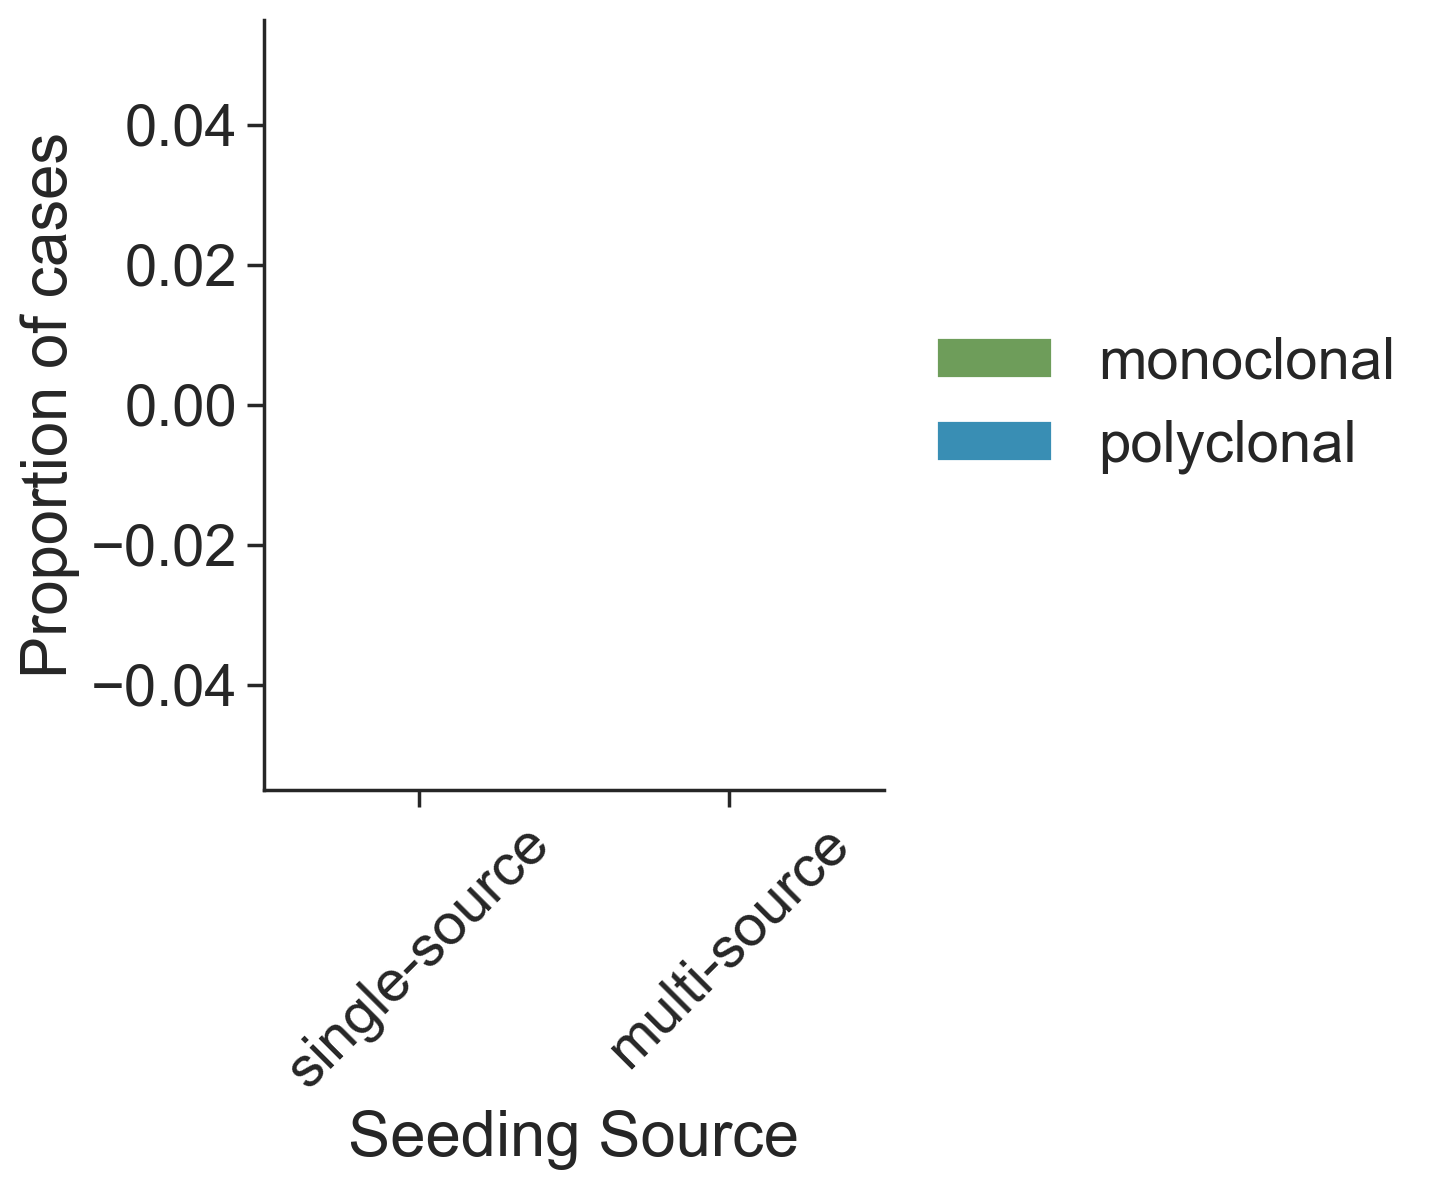

In [8]:
data = {"mono_poly" : [], "source" : [], "patient":[]}
for key, pattern in conipher_mp_gd_seeding_patterns.items():
    patient = key.split("_")[0]
    data["patient"].append(patient)
    data["mono_poly"].append(pattern.split()[0])
    data["source"].append(pattern.split()[1])

# Create a DataFrame
patterns_df = pd.DataFrame(data)
print(patterns_df)

# Reorder the DataFrame based on the custom order
custom_order = ["single-source", "multi-source",]
patterns_df['source'] = pd.Categorical(patterns_df['source'], categories=custom_order, ordered=True)
patterns_df.sort_values('source', inplace=True)

# Calculate the proportions of monoclonal and polyclonal within each source
proportions = patterns_df.groupby(['source', 'mono_poly']).size().unstack(fill_value=0).div(patterns_df.groupby('source').size(), axis=0)

# Reset the index
proportions.reset_index(inplace=True)

sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(4, 5), dpi=200)

# Create a stacked bar plot,
ax1 = sns.barplot(x='source', y='monoclonal', data=proportions, color="#6aa84fff", label='monoclonal')
ax2 = sns.barplot(x='source', y='polyclonal', data=proportions, color="#2496c8ff", bottom=proportions['monoclonal'], label='polyclonal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add labels and legend
plt.xlabel("Seeding Source")
plt.ylabel("Proportion of cases")
plt.xticks(rotation=45)
plt.title("")
plt.legend(title="",  loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Show the plot
plt.show()
fig.savefig(os.path.join(REPO_DIR, "src/test", f"source_and_seeding_distribution.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [9]:
patterns_df[["mono_poly", "source"]].value_counts()

Series([], Name: count, dtype: int64)

In [10]:
df = pd.DataFrame(mono_poly_data)
len(df[(df['mono_poly']=='monoclonal')])

47

### How concordant are our seeding patterns with TRACERx's?

In [11]:
tracerx_seeding = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "seedingTable.txt"), sep="\t")
tracerx_seeding.columns = ["patient_id", "tracerx_clonality","tracerx_phyletic", "tracerx_multitree_adjustment"] 
print(len(tracerx_seeding))
print(conipher_mp_gd_seeding_patterns)
tracerx_seeding['metient_clonality'] = tracerx_seeding.apply(lambda row: conipher_mp_gd_seeding_patterns[row['patient_id']].split()[0] if row['patient_id'] in conipher_mp_gd_seeding_patterns else "", axis=1)
tracerx_seeding['metient_phyletic'] = tracerx_seeding.apply(lambda row: conipher_mp_gd_seeding_patterns[row['patient_id']].split()[1] if row['patient_id'] in conipher_mp_gd_seeding_patterns else "", axis=1)

tracerx_seeding

126
{'CRUK0495': 'monoclonal monophyletic', 'CRUK0284': 'polyclonal polyphyletic', 'CRUK0497': 'polyclonal polyphyletic', 'CRUK0041': 'no seeding', 'CRUK0236': 'monoclonal monophyletic', 'CRUK0418': 'no seeding', 'CRUK0737': 'monoclonal monophyletic', 'CRUK0044': 'monoclonal monophyletic', 'CRUK0872': 'polyclonal polyphyletic', 'CRUK0245': 'polyclonal polyphyletic', 'CRUK0584': 'polyclonal polyphyletic', 'CRUK0693': 'no seeding', 'CRUK0325': 'polyclonal polyphyletic', 'CRUK0361': 'monoclonal monophyletic', 'CRUK0572': 'polyclonal polyphyletic', 'CRUK0453': 'monoclonal monophyletic', 'CRUK0412': 'no seeding', 'CRUK0636': 'monoclonal monophyletic', 'CRUK0519': 'monoclonal monophyletic', 'CRUK0097': 'monoclonal monophyletic', 'CRUK0299': 'polyclonal polyphyletic', 'CRUK0596': 'polyclonal polyphyletic', 'CRUK0178': 'polyclonal polyphyletic', 'CRUK0444': 'polyclonal polyphyletic', 'CRUK0084': 'monoclonal monophyletic', 'CRUK0337': 'monoclonal monophyletic', 'CRUK0524': 'monoclonal monophyle

,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_clonality,metient_phyletic
0,CRUK0010,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic
1,CRUK0013,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic
2,CRUK0284,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic
3,CRUK0361,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic
4,CRUK0497,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic
...,...,...,...,...,...,...
121,CRUK0495,polyclonal,monophyletic,monophyletic,monoclonal,monophyletic
122,CRUK0476,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic
123,CRUK0528,polyclonal,polyphyletic,polyphyletic,polyclonal,polyphyletic
124,CRUK0666,polyclonal,polyphyletic,polyphyletic,no,seeding


In [17]:
num_same_clonality = tracerx_seeding[tracerx_seeding['tracerx_clonality']==tracerx_seeding['metient_clonality']]
print(len(num_same_clonality))
num_same_phyletic = tracerx_seeding[tracerx_seeding['tracerx_multitree_adjustment']==tracerx_seeding['metient_phyletic']]
print(len(num_same_phyletic))
num_same = tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']==tracerx_seeding['metient_phyletic'])&(tracerx_seeding['tracerx_clonality']==tracerx_seeding['metient_clonality'])]
print(len(num_same))


59
47
43
